In [1]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#change current working directory
%cd "/content/drive/Shareddrives/NLI"

/content/drive/Shareddrives/NLI


In [3]:
!pip install transformers
!pip install accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import AdamW
from transformers import EarlyStoppingCallback, IntervalStrategy
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score, precision_score, f1_score
from torch import cuda
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from itertools import product
import os
import joblib
import json
import math

In [5]:
# Run it only once
from datasets import load_dataset
#dataset = load_dataset("multi_woz_v22")

In [6]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
# Run it only once
#dataset.save_to_disk("dataset.hf")

In [8]:
from datasets import DatasetDict
dataset = DatasetDict.load_from_disk("dataset.hf")

In [9]:
def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service.startswith('Restaurant'):
            services.add(service)
        elif service.startswith('Hotel'):
            services.add(service)
        elif service.startswith('general'):
            services.add(service)
        else:
            services.add('other')
    return list(services)

In [10]:
def extract_utterance_and_act_types(dataset):
    act_types = []
    utterance_list = []

    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        # print(dataset.loc[i].turns['utterance'])
        # print([frame['service'] for frame in dataset.loc[i].turns['frames']])
        for utterance, speaker, dialogue_act in zip(turns['utterance'], turns['speaker'], turns['dialogue_acts']):
            if speaker == 0: # if it's the user's turn
                act_type = dialogue_act['dialog_act']['act_type']
                act_type = process_service_list(act_type)
                utterance = re.sub("[^a-zA-Z0-9]", " ", utterance) #remove everything that is not alphabet or digit
                utterance = utterance.lower() #make lowercase
                utterance = " ".join(utterance.split()) #remove whitespaces
                utterance_list.append(utterance)
                act_types.append(act_type)


    return utterance_list, act_types

In [11]:
train_utterances, train_act_types = extract_utterance_and_act_types(dataset['train'].to_pandas())
test_utterances, test_act_types = extract_utterance_and_act_types(dataset['test'].to_pandas())
valid_utterances, valid_act_types = extract_utterance_and_act_types(dataset['validation'].to_pandas())


100%|██████████| 1000/1000 [00:00<00:00, 1340.60it/s]


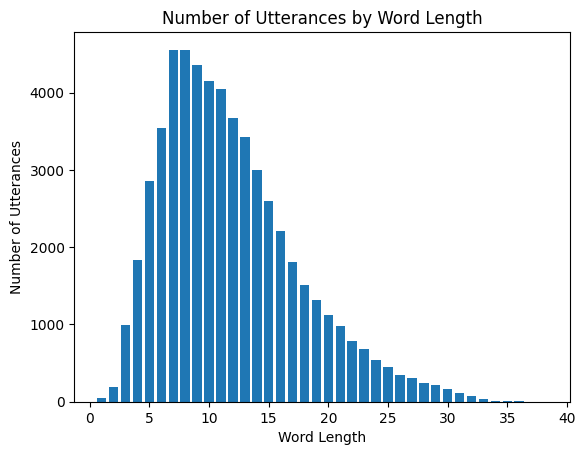

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract word lengths from each utterance
word_lengths = [len(utterance.split()) for utterance in train_utterances]

# Count the number of utterances with each word length
word_length_counts = Counter(word_lengths)

# Extract unique word lengths and their corresponding counts
unique_word_lengths = list(word_length_counts.keys())
count_of_word_lengths = [word_length_counts[length] for length in unique_word_lengths]

# Create a bar graph
plt.bar(unique_word_lengths, count_of_word_lengths)

# Set labels for the axes
plt.xlabel("Word Length")
plt.ylabel("Number of Utterances")

# Set the title of the graph
plt.title("Number of Utterances by Word Length")

# Show the graph
plt.show()


In [13]:
num_dialog_acts = len(set([act for act_list in train_act_types for act in act_list ]))

In [14]:
all_labels = set([act for act_list in train_act_types for act in act_list ])
print(all_labels)

{'other', 'general-greet', 'Hotel-Request', 'general-bye', 'general-thank', 'Restaurant-Inform', 'Hotel-Inform', 'Restaurant-Request'}


In [15]:
# This will help us to transform the labels into a one-hot encoded numeric array
mlb = MultiLabelBinarizer(classes=list(all_labels))

In [16]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [17]:
class DialogueActDataset(Dataset):
    def __init__(self, tokenizer, utterances, labels):
        self.utterances = utterances
        self.tokenizer = tokenizer
        # Fit the label binarizer and transform the labels into one-hot encoded format
        self.labels = mlb.fit_transform(labels)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        # Encode the utterance using the provided tokenizer
        encoding = self.tokenizer.encode_plus(
            self.utterances[idx],
            add_special_tokens=True,
            max_length=40,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        # Convert the list of strings into a one-hot encoded format
        label = self.labels[idx]  # This should now be a binary vector instead of a list of strings
        # Return the encoding and the label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [18]:
# Smaller dataset to try
p = 1
n_train_samples = int(len(train_utterances) * p)
n_test_samples = int(len(test_utterances) * p)
n_valid_samples = int(len(valid_utterances) * p)

print("Train samples: ", n_train_samples)
print("Test samples: ", n_test_samples)
print("Valid samples: ", n_valid_samples)

Train samples:  56776
Test samples:  7372
Valid samples:  7374


In [19]:
train_dataset = DialogueActDataset(tokenizer, train_utterances[:n_train_samples], train_act_types[:n_train_samples])
test_dataset = DialogueActDataset(tokenizer, test_utterances[:n_test_samples], test_act_types[:n_test_samples])
valid_dataset = DialogueActDataset(tokenizer, valid_utterances[:n_valid_samples], valid_act_types[:n_valid_samples])

## Evaluation

In [20]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
def eval_model(model, test_data):
  predictions = []
  true_labels = []

  with torch.no_grad():
    for batch in test_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      logits = outputs.logits
      predictions.extend(logits.detach().cpu().numpy())
      true_labels.extend(batch['labels'].detach().cpu().numpy())

  # Apply softmax to logits and then take the argmax to get the most likely label
  sigmoid_outputs = torch.sigmoid(torch.tensor(np.array(predictions)))
  threshold = 0.5
  binary_predictions = (sigmoid_outputs > threshold).numpy()  # Applying a threshold to get binary values

  # Calculate the metrics
  accuracy = accuracy_score(true_labels, binary_predictions)

  precision, recall, f1, support = precision_recall_fscore_support(true_labels, binary_predictions, average='micro', zero_division=0.0)

  print("Accuracy:",accuracy, "\nPrecision:", precision,"\nRecall:", recall,"\nF1-score:", f1)

  # Generate a classification report
  report = classification_report(true_labels, binary_predictions, target_names=mlb.classes_)
  print(report)

  return accuracy, precision, recall, f1, support, report

## Training

In [22]:
lrs = [1e-5, 1e-4]
batch_sizes = [8, 16]
num_epochs = [10]
warmup_steps = [500]
weight_decays = [0.01, 0.001]

In [23]:
# Generate all possible permutations of hyperparameter values
hyperparameter_combinations = list(product(lrs, batch_sizes, num_epochs, warmup_steps, weight_decays))

In [24]:
hyperparameter_combinations

[(1e-05, 8, 10, 500, 0.01),
 (1e-05, 8, 10, 500, 0.001),
 (1e-05, 16, 10, 500, 0.01),
 (1e-05, 16, 10, 500, 0.001),
 (0.0001, 8, 10, 500, 0.01),
 (0.0001, 8, 10, 500, 0.001),
 (0.0001, 16, 10, 500, 0.01),
 (0.0001, 16, 10, 500, 0.001)]

In [25]:
# Name of the JSON file
tried_name = 'model/dialog_act_tried.json'

def get_best_model_spec():
  try:
      # Open the file
      with open(tried_name, 'r') as file:
          # Load the values
          best_hyp, best_f1, tried_hyp = json.load(file)

  except FileNotFoundError:
      best_hyp = ()
      best_f1 = 0
      tried_hyp = []

  return best_hyp, best_f1, tried_hyp

In [26]:
def compute_metrics(p):
    predictions, true_labels = p

    # Apply softmax to logits and then take the argmax to get the most likely label
    sigmoid_outputs = torch.sigmoid(torch.tensor(np.array(predictions)))
    threshold = 0.5
    binary_predictions = (sigmoid_outputs > threshold).numpy()  # Applying a threshold to get binary values

    # Calculate the metrics
    accuracy = accuracy_score(true_labels, binary_predictions)

    precision, recall, f1, support = precision_recall_fscore_support(true_labels, binary_predictions, average='micro', zero_division=0.0)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
for lr, batch_size, epochs, warmup, weight in hyperparameter_combinations:
    # Define training arguments
    #weight = weight * math.sqrt(batch_size / (n_train_samples * epochs))
    if [lr, batch_size, epochs, warmup, weight] in get_best_model_spec()[2]:
      print('Model', [lr, batch_size, epochs, warmup, weight], 'already trained')
      continue

    print('Training: ', [lr, batch_size, epochs, warmup, weight])

    # Load the pre-trained BERT model and tokenizer
    model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=num_dialog_acts)
    model.train()

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs = epochs,
        warmup_steps = warmup,
        weight_decay = weight,
        learning_rate = lr,

        evaluation_strategy = 'epoch', # "steps"
        eval_steps = 500, # Evaluation and Save happens every 50 steps
        save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,

        push_to_hub=False,
        metric_for_best_model = 'f1',
        load_best_model_at_end=True,
        save_strategy='epoch'
          )

    # Create a Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset= train_dataset,
        eval_dataset = valid_dataset,
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train the model
    trainer.train()

    # Put the model in evaluation mode
    model.eval()

    accuracy, precision, recall, f1, support, report = eval_model(model, test_dataloader)

    spec = 'lr= ' + str(lr) + ' batch= ' + str(batch_size) + ' epochs= '+ str(epochs)+' warmup= '+str(warmup)+' weight= '+str(weight) + '\nAccuracy= '+ str(accuracy) +'\nF1-score= '+ str(f1)

    current_hyp = (lr, batch_size, epochs, warmup, weight)

    if f1 > get_best_model_spec()[1]:

      print('Better model found:', spec)
      trainer.save_model('model/best_model_act_dialog')

      best_hyp, best_f1, tried_hyp = get_best_model_spec()
      tried_hyp.append(current_hyp)

      # Open the file
      with open(tried_name, 'w') as file:
        # Load the values
        json.dump((current_hyp, f1, tried_hyp), file)

    else:
      print('Worse F1 score for', spec)

      best_hyp, best_f1, tried_hyp = get_best_model_spec()
      tried_hyp.append(current_hyp)

      # Open the file
      with open(tried_name, 'w') as file:
        # Load the values
        json.dump((best_hyp, best_f1, tried_hyp), file)


Training:  [1e-05, 8, 10, 500, 0.01]


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.072100,0.068458,0.846216,0.923256,0.870189,0.895937
2,0.063900,0.064184,0.860862,0.933407,0.878068,0.904892
3,0.058300,0.068173,0.872932,0.923087,0.889822,0.906149
